<h1>Experimentation Notebook for Twitter Sentiment Analysis</h1>
This notebook covers all work done in building the backend portion of the Twitter Sentiment Trend app

<h3> Initializing packages and datasets </h3>

In [10]:
# Importing necessary packages + initializing settings
import pandas as pd
import datetime
import numpy as np
import nltk
import re
import tweepy
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from collections import Counter
from string import punctuation
import matplotlib.pyplot as plt
from secrets import * # Contains the OAuth authentication tokens.

# Loading data
# training_data = pd.read_csv("./twitter_training.csv", index_col=0, names=["Index","Entity","Sentiment","Tweet"])
testing_data = pd.read_csv("./twitter_validation.csv", index_col=0, names=["Index","Entity","Sentiment","Tweet"])

# Converting indices in dataset to a list
indices = testing_data.index.values.tolist()

<h3> Defining <code>clean_tweet</code> function </h3>

The function processes a raw tweet and returns a list of words separated by space characters + the hashtags used in the tweet.
The code removes special characters, punctuation, numbers and stopwords (e.g., "a", "the", "for", etc.).

In [11]:
def clean_tweet(tweet):
    """
    This function processes the tweet into a string array for NLP sentiment analysis.    
    """

    # Removing RT from tweet (can't figure out how to filter out retweets with Twitter APIv2)
    remove_RT = lambda x: re.compile('RT @').sub('@',x,count=1).strip() 
    tweet = remove_RT(tweet)

    # Removing mentions with regex
    tweet = re.sub(r'@[A-Za-z0-9_]+', '', tweet)

    # Removing links
    tweet = re.sub(r"http\S+", "", tweet)
    tweet = re.sub(r"www.\S+", "", tweet) 

    # Extracting then removing hashtags
    hashtags = re.findall(r"#(\w+)", tweet)
    tweet = re.sub("#[A-Za-z0-9_]+","", tweet)

    # Converting uppercase characters
    tweet = tweet.lower()

    # Splitting up all words into array of strings
    tokens = tweet.split()

    # Removing punctuation
    table = str.maketrans(" "," ",punctuation)
    tokens = [w.translate(table) for w in tokens]

    # Removing numerical characters
    token = [w for w in tokens if w.isalpha()]

    # Removing stopwords e.g., "a", "the", "for", etc.
    stop_words = stopwords.words("english")
    new_tweet = [w for w in token if w not in stop_words]


    return ' '.join(new_tweet), hashtags

<h3> Defining <code>analyze_tweet</code> function </h3>

This function returns statistics on processed set of tweets.
Returns frequency data as well as sentiment analysis.

In [12]:
'''
This function returns statistics on processed set of tweets.
Returns frequency data as well as sentiment analysis.
'''

def analyze_tweet(input_tweets):

    all_sentiment = []

    count = 0

    for idx in range(len(input_tweets)):   
        temp = sentiment_analyzer.polarity_scores(input_tweets[idx])
        all_sentiment.append(temp["compound"])

    
    #freq_dist_tweet = nltk.FreqDist(input_tweets) 

    # Acquiring frequency distribution of words
    counts = Counter(str(input_tweets).split())

    labels, values = zip(*counts.items())

    word_labels = np.array(labels)[np.argsort(values)[::-1]]
    word_counts = np.array(values)[np.argsort(values)[::-1]]

    return all_sentiment, word_counts, word_labels

<h3> Data collection function <code> collect_data </code> </h3>

Collects tweet data (date and text) when keyword is entered.

In [13]:
def collect_data(keyword,api):
    # result = {"time":[], "text":[]}
    date_until = datetime.datetime.now()
    number_of_tweets = 100
    
    # Will query up to 7 days maximum
    tweets = api.search_recent_tweets(query=keyword,
                                max_results=number_of_tweets,
                                end_time=date_until,
                                tweet_fields=["text","created_at"])

    raw_tweets = []
    tweet_time = []
    
    for twt in tweets.data:
        raw_tweets.append(twt.text)
        tweet_time.append(twt.created_at)
    
    result = {"time": tweet_time, "text":raw_tweets}
    

    return result

<h3> Rolling average function <code> moving_average </code> implemented with <code> cumsum </code> </h3>

In [14]:
def moving_average(a, n=3):
    
    # Cumulative sum
    ret = np.cumsum(a, dtype=float)

    # Calculating mean
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

<h4> Example of <code> clean_tweet </code> function

In [15]:
# Testing tweet cleaner
token_tweets = []
hashtags = []

for idx in indices:
    tweett,hasht = clean_tweet(testing_data.Tweet.loc[idx])
    token_tweets.append(tweett)
    hashtags.append(hasht)


In [16]:
# Original tweet
idx = 22
print(testing_data.Tweet.loc[indices[idx]])

Call of duty warzone (livestream) w/ subs #Warzone youtu.be/7BhH_pjOMU4 via @YouTube Please come watch this AMAZING Call of Duty Warzone stream from this AMAZING streamer! It'd be really, really nice to give him some views and likes as well! 😀 #COD #CallofDuty #Warzone


In [17]:
# Clean output
print(token_tweets[idx])
print("Hashtags=",hashtags[idx])

call duty warzone livestream w subs via please come watch amazing call duty warzone stream amazing streamer itd really really nice give views likes well
Hashtags= ['Warzone', 'COD', 'CallofDuty', 'Warzone']


<h4> Testing <code> FreqDist </code> method of <code> nltk </code> </h4>
Wanted to use this method for word count analysis but doesn't seem to work well...

In [18]:
freq_dist_tweet = nltk.FreqDist(token_tweets)
freq_dist_tweet.most_common(3)

[('played interesting quiz amazon try luck chance win exciting rewards', 5),
 ('red dead redemption', 4),
 ('wow', 3)]

<h4> Testing in-house solution for word count analysis </h4>
Uses <code>Counter()</code> method from <code>collections</code> module

In [19]:
counts_test = Counter(str(token_tweets).split())

import itertools
dict(itertools.islice(counts_test.items(),10))

{"['mentioned": 1,
 'facebook': 21,
 'struggling': 2,
 'motivation': 1,
 'go': 28,
 'run': 7,
 'day': 22,
 'translated': 1,
 'great': 21,
 'auntie': 1}

<h4> Testing sentiment analyzer output </h4>
<code> polarity_scores </code> returns 4 values. The first 3 are on a scale of 0 to 1 and indicate presence of negativity (<code> neg </code>), neutrality (<code> neu </code>) or positivity (<code> pos </code>). The fourth value <code> compound </code> is on a scale of -1 to +1 and is calculated separately. 

In [20]:
# Testing sentiment analyzer
idx = 1
sentiment_analyzer = SentimentIntensityAnalyzer()
print(testing_data.Tweet.loc[indices[idx]])
print(sentiment_analyzer.polarity_scores(token_tweets[idx]))
print(testing_data.Sentiment.loc[indices[idx]])


BBC News - Amazon boss Jeff Bezos rejects claims company acted like a 'drug dealer' bbc.co.uk/news/av/busine…
{'neg': 0.184, 'neu': 0.575, 'pos': 0.241, 'compound': -0.0}
Neutral


<h4> Benchmarking <code> nltk</code> sentiment analyzer with true results </h4>
The accuracy of the sentiment analyzer is benchmarked using the true results. For the purposes of testing, 'irrelevant' and 'neutral' were grouped together. The 'neutral' category was thresholded as being between a compound value of -0.45 to 0.45. Smaller numbers were deemed to be negative and larger numbers were deemed to be positive.

The rates calculated indicate higher accuracy as the fraction approaches 1. Values greater than 1 represent overshooting by the model, and values less than 1 represent undershooting. Accuracy can be changed as the threshold is tweaked, representing some ambiguity in the definition of "neutral" in the analyzer.

In [21]:
pos_count_true = 0
neg_count_true = 0
neu_count_true = 0

pos_count_model = 0
neg_count_model = 0
neu_count_model = 0

sentiment, word_counts, word_labels = analyze_tweet(token_tweets)

for idx in range(len(sentiment)):

    if testing_data.Sentiment.loc[indices[idx]]=='Positive':
        pos_count_true+=1
    elif testing_data.Sentiment.loc[indices[idx]]=='Negative':
        neg_count_true+=1
    else:
        neu_count_true+=1


    if sentiment[idx] > 0.45:
        pos_count_model+=1
    elif sentiment[idx] < -0.45:
        neg_count_model+=1
    else:
        neu_count_model+=1


model_accuracy = [pos_count_model/pos_count_true,
                    neg_count_model/neg_count_true,
                    neu_count_model/neu_count_true]

# Closer to 1 is better
print("True positive rate:",round(model_accuracy[0],2),
"\nTrue negative rate:",round(model_accuracy[1],2),
"\nTrue neutral rate:",round(model_accuracy[2],2))

# Calculating rolling average of sentiments
rolling_sentiment = moving_average(sentiment)


True positive rate: 1.26 
True negative rate: 0.98 
True neutral rate: 0.86


Text(0.5, 1.0, 'Sentiment of tweets')

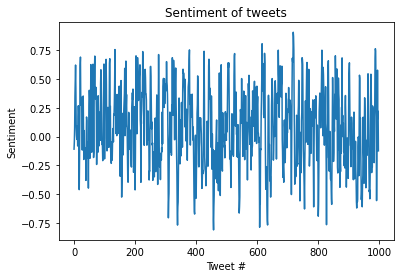

In [22]:
plt.figure
plt.plot(rolling_sentiment)
plt.xlabel("Tweet #")
plt.ylabel("Sentiment")
plt.title("Sentiment of tweets")

<BarContainer object of 10 artists>

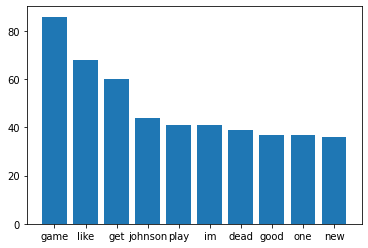

In [23]:
plt.figure
plt.bar(word_labels[0:10],word_counts[0:10])


<h3> Testing Twitter API... </h3>

In [24]:
keys_file = open("secrets.txt")
lines = keys_file.readlines()

BEARER_TOKEN = lines[0].rstrip()
CONSUMER_KEY = lines[1].rstrip()
CONSUMER_SECRET = lines[2].rstrip()
ACCESS_TOKEN = lines[3].rstrip()
ACCESS_TOKEN_SECRET = lines[4].rstrip()

api = tweepy.Client(BEARER_TOKEN,CONSUMER_KEY, CONSUMER_SECRET, ACCESS_TOKEN, ACCESS_TOKEN_SECRET)

import urllib.parse
keyword = "covid-19"

keyword = keyword + " lang:en"

raw_tweet_data = collect_data(keyword,api)


<h3> Printing out example tweet + time created </h3>

In [25]:
print(str(raw_tweet_data["time"][1]))
print(raw_tweet_data["text"][1])


2022-05-11 10:15:55+00:00
RT @BrandonStraka: GoFundMe shut down a fundraiser for an 8-year-old girl injured after taking Pfizer’s COVID-19 shot.

The left is going a…


In [26]:
processed_tweets = []
hashtags = []
for idx in range(len(raw_tweet_data["text"])):
    temptweet, temphash = clean_tweet(str(raw_tweet_data["text"][idx]))
    processed_tweets.append(temptweet)
    hashtags.append(temphash)

idxt = 10
print(str(raw_tweet_data["text"][idxt]))  
print("\nClean tweet") 
print(processed_tweets[idxt])
print("Hashtags =",hashtags[idxt])


RT @LaurenDue12: 🚨The FDA has issued the most serious type of recall for Skippack Medical Lab’s SARSCoV2 Antigen Rapid Test Kit (Colloidal…

Clean tweet
fda issued serious type recall skippack medical antigen rapid test kit
Hashtags = []


Text(0.5, 1.0, 'Sentiment')

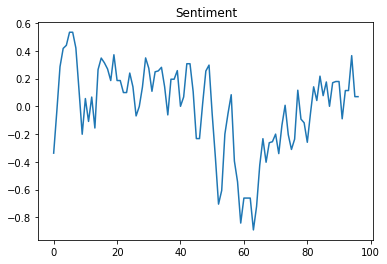

In [27]:
sentiment, word_counts, word_labels = analyze_tweet(processed_tweets)

# Calculating rolling average of sentiments
rolling_sentiment = moving_average(sentiment)

plt.figure
plt.plot(rolling_sentiment)
plt.title("Sentiment")

<BarContainer object of 5 artists>

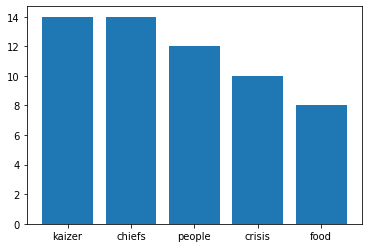

In [28]:
plt.figure
plt.bar(word_labels[0:5],word_counts[0:5])